---
title: From Discrete Transformations to Continuous Flows
author: Mark Fuge
date: 'October 26 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

We saw in the last chapter how normalizing flows transform simple base distributions into complex target distributions via a sequence of invertible mappings. Each mapping requires computing the determinant of the Jacobian to track how densities change.

In continuous normalizing flows, we ask: what happens if we let the number of layers go to infinity while shrinking each individual transformation to an infinitesimal step? That is, rather than a handful of large invertible maps, we stack infinitely many tiny, smooth updates. We will see that taking this limit produces an ordinary differential equation (ODE) whose solution transports probability mass. 

## Learning Objectives

By the end of this notebook you should be able to:

- Recognize that a CNF is the infinitesimal limit of a discrete normalizing flow.
- Explain how the log-density evolves through the divergence of a velocity field.
- Derive the continuity equation from the change-of-variables formula.
- Simulate simple continuous flows and verify how densities change.
- Connect CNFs to probability transport ideas and the diffusion models we will meet later.

## From Finite Jacobians to Differential Updates
As we saw last chapter, in a discrete flow the change-of-variables formula is:
$$
\log p(x) = \log p(z_K) = \log p(z_0) - \sum_{i=1}^{K} \log\left|\det J_{f_i}(z_{i-1})\right|.
$$

for a sequence of $K$ invertible maps $f_i$ transforming a base sample $z_0$ to a target sample $x=z_K$. Here, $J_{f_i}$ is the Jacobian of the $i$-th transformation.

If we instead consider an infinite sequence of infinitesimal transformations, we can think of each layer as a tiny residual step: $z_{i+1} = z_i + \varepsilon v(z_i, t_i)$ where $\varepsilon$ is a small step size, $v$ is a velocity field, and $t_i$ is a time index. The change in probability density can then be thought of as an integral over these infinitesimal changes, like particles flowing through a fluid governed by the velocity field. The main learning challenge here is to learn the right velocity field $v(z, t)$ that transports our simple base distribution to our desired target distribution over time, and also to solve this ODE inexpensively.

Concretely, rather than consider a single step of the change of variables formula, we consider the limit as $\varepsilon \to 0$ of many small steps, which gives rise to the *instantaneous change of variables* formula[^1]:
$$
\frac{\partial}{\partial t} \log p(z(t)) = -\operatorname{tr}\left( \nabla_x v(z(t), t) \right),
$$

where $\nabla_x v$ is the Jacobian of the velocity field with respect to $z$, and $\operatorname{tr}$ denotes the trace of a matrix.

[^1]: For the full derivation, see e.g. [Chen et al., 2018](https://arxiv.org/abs/1806.07366) Appendix A.

Now, given a vector field $v(z, t)$, we can compute how a base density $p(z_0)$ evolves into the final distribution $p(x)=p(z_K)$ via:
$$
\log p(x) = \log p(z_0) - \int_{0}^{T} \operatorname{tr}\left( \nabla_x v(z(t), t) \right) \, \mathrm{d}t.
$$

We can think of this as starting a distribution at time $t=0$ (i.e., at $p(z_0)$) and then integrating it through the velocity field $v(z, t)$ until time $t=T$, where we hope to recover the distribution of the training data (i.e., $p(x)$). To find the best velocity field, we can optimize the above expression for $\log p(x)$ with respect to the parameters of $v(z, t)$ using maximum likelihood. For neural network-based parameterizations of $v(z, t)$ we would parameterize the velocity field via neural network weights and denote this $v_\theta(z,t)$ where $\theta$ are the neural network weights. The main requirement we have for the velocity field $v(z, t)$ is that it (and its first derivative) must be Lipschitz continuous so that the resulting ODE has a unique solution (and thus can be in principle inverted as well). We can enforce the Lipschitz continuity of $v_\theta$ by choosing activations that have bounded Lipschitz constants, and then further control the smoothnessness of the velocity field by regularizing the weights (e.g., via spectral normalization).

Putting all of this together, and following the notation/construction of [Grathwohl et al. 2019](https://arxiv.org/pdf/1810.01367), we can summarize the continuous normalizing flow (CNF) model as the following Initial Value Problem (IVP), based on the above ODE:
$$
\underbrace{\begin{bmatrix}
\mathbf{z}_0 \\
\log p(\mathbf{x}) - \log p_{\mathbf{z}_0}(\mathbf{z}_0)
\end{bmatrix}}_{\text{solutions}}
= 
\int_{t_1}^{t_0} 
\underbrace{\begin{bmatrix}
v_\theta(\mathbf{z}(t),t) \\
-\mathrm{tr}\!\left(\frac{\partial v_\theta}{\partial \mathbf{z}(t)}\right)
\end{bmatrix}}_{\text{dynamics}} 
\, dt,
\quad
\underbrace{\begin{bmatrix}
\mathbf{z}(t_1) \\
\log p(\mathbf{x}) - \log p(\mathbf{z}(t_1))
\end{bmatrix}}_{\text{initial values}}
=
\begin{bmatrix}
\mathbf{x} \\
0
\end{bmatrix}.
$$  

Which we can see involves solving the ODE backwards in time from $t_1 = T$ to $t_0 = 0$ and can recover both the latent variable $\mathbf{z}_0$ and the log-density $\log p(\mathbf{x})$ given a training sample $\mathbf{x}$.

Solving this IVP can be done in many ways, including using existing ODE solvers like Runge-Kutta methods or adaptive solvers, and the cost is largely determined by the complexity of the velocity field and the stiffness of the ODE, since more complex velocity fields may require more function evaluations to accurately solve the ODE. An important caveat to this is that the solver must be itself differentiable, since we need to be able to differentiate through it to see how to modify the vector field. This is not the case for many existing ODE solvers you may have used.[^2] Further techniques are used to reduce the computational burden, such through the use of Jacobian-vector products to compute the trace term efficiently, the use of the Hutchinson's trace estimator, as well as regularization methods to ensure smoothness of the velocity field, which can help in reducing the number of function evaluations needed during ODE solving, but these details are beyond the scope of this book. For further details see the original paper by [Chen et al., 2018](https://arxiv.org/abs/1806.07366) and the follow-up work by [Grathwohl et al., 2019](https://arxiv.org/pdf/1810.01367).

[^2]: Interestingly enough, we showed in our [review of automatic differentiation](../../part1/taking_derivatives.ipynb) how to make a Verlet Integrator differentiable. In practice, one could use an existing ODE solver that was designed to be differentiable, such as `torchdiffeq` in PyTorch, which we will use in the experiments below.

To gain some intuition about continuous flows, we will do a couple of simple experiments using a simple flow integrator using Runge-Kutta 45 -- in practice you could use an existing solver or customized code with some of the advanced tricks mentioned above, but this will allow us to get the main concept across with minimal code complexity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from typing import Callable, Tuple
import torch.optim as optim

plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

device = "cpu"

In [ ]:
#| code-fold: false
Tensor = torch.Tensor

# Fourth-order Runge-Kutta (RK4) integrator step
def rk4_step(field: Callable[[Tensor, float], Tensor], x: Tensor, t: float, dt: float) -> Tensor:
    k1 = field(x, t)
    k2 = field(x + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = field(x + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = field(x + dt * k3, t + dt)
    return x + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

# Integrate flow using RK4
def integrate_flow(
    field: Callable[[Tensor, float], Tensor],
    x0: Tensor,
    t_span: Tuple[float, float] = (0.0, 1.0),
    steps: int = 100,
    record: bool = False,
):
    t0, t1 = t_span
    dt = float(t1 - t0) / steps
    x = x0.clone()
    t = float(t0)
    history = []
    if record:
        history.append(x.detach().cpu().numpy())
    for _ in range(steps):
        x = rk4_step(field, x, t, dt)
        t += dt
        if record:
            history.append(x.detach().cpu().numpy())
    if record:
        times = np.linspace(t0, t1, steps + 1)
        return x, np.stack(history), times
    return x

# Integrate flow and log-probability using RK4
def integrate_flow_with_logp(
    field: Callable[[Tensor, float], Tensor],
    divergence_fn: Callable[[Tensor, float], Tensor],
    x0: Tensor,
    logp0: Tensor,
    t_span: Tuple[float, float] = (0.0, 1.0),
    steps: int = 100,
):
    t0, t1 = t_span
    dt = float(t1 - t0) / steps
    x = x0.clone()
    logp = logp0.clone()
    t = float(t0)
    for _ in range(steps):
        div = divergence_fn(x, t)
        logp = logp - dt * div
        x = rk4_step(field, x, t, dt)
        t += dt
    return x, logp

# Estimate divergence
def estimate_divergence_autograd(field: Callable[[Tensor, float], Tensor], x: Tensor, t: float) -> Tensor:
    x = x.clone().detach().requires_grad_(True)
    v = field(x, t)
    components = []
    for idx in range(v.shape[1]):
        grad = torch.autograd.grad(v[:, idx].sum(), x, retain_graph=idx < v.shape[1] - 1)[0][:, idx]
        components.append(grad)
    return torch.stack(components, dim=1).sum(dim=1)

## Example: Divergence-Free Rotation

Consider the velocity field $v(x, y) = (-y, x)$. Its divergence is zero, so the flow should rotate particles without changing their density. We integrate a few trajectories and compare a cloud of points before and after one full revolution.

In [3]:
#| code-fold: false
def rotation_field(x: Tensor, t: float) -> Tensor:
    return torch.stack([-x[:, 1], x[:, 0]], dim=1)

cloud0 = torch.randn(800, 2, device=device)
cloudT = integrate_flow(rotation_field, cloud0, t_span=(0.0, 2 * np.pi), steps=200)

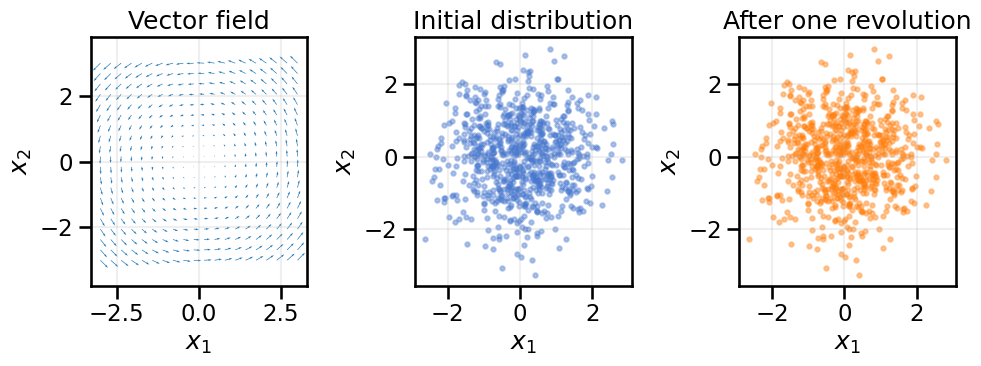

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the vector field corresponding to the rotation
x1 = np.linspace(-3, 3, 20)
x2 = np.linspace(-3, 3, 20)
X1, X2 = np.meshgrid(x1, x2)
U = -X2
V = X1

axes[0].quiver(X1, X2, U, V, color='tab:blue')
axes[0].set_title('Vector field')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)

axes[1].scatter(cloud0[:, 0].cpu(), cloud0[:, 1].cpu(), s=10, alpha=0.4)
axes[1].set_title('Initial distribution')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)

axes[2].scatter(cloudT[:, 0].cpu(), cloudT[:, 1].cpu(), s=10, alpha=0.4, color='tab:orange')
axes[2].set_title('After one revolution')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

Because $\nabla_x \cdot v = 0$, every particle completes a rotation on a circle of constant radius. The density of the cloud is unchanged, illustrating how divergence controls instantaneous volume change.

## Example: Contracting Divergence Controls Density Growth

Now take the compressible velocity field $v(x, y) = (-x, -y)$. The divergence is $-2$, so the log-density should increase as $\frac{\mathrm{d}}{\mathrm{d}t} \log p = 2$. We'll integrate particles, track log-density, and compare to the analytic solution $x(t) = e^{-t} x(0)$.

In [5]:
#| code-fold: false
def contracting_field(x: Tensor, t: float) -> Tensor:
    return -x

divergence_contracting = -2.0
torch.manual_seed(21)
z0 = torch.randn(2000, 2, device=device)
logp0 = -0.5 * torch.sum(z0 ** 2, dim=1) - np.log(2 * np.pi)
T_final = 1.5
zT, logpT_est = integrate_flow_with_logp(
    contracting_field,
    lambda x, t: torch.full((x.shape[0],), divergence_contracting, device=x.device),
    z0,
    logp0,
    t_span=(0.0, T_final),
    steps=200,
)
scale = torch.exp(torch.tensor(-T_final))
analytic_zT = z0 * scale
analytic_logp = logp0 - divergence_contracting * T_final

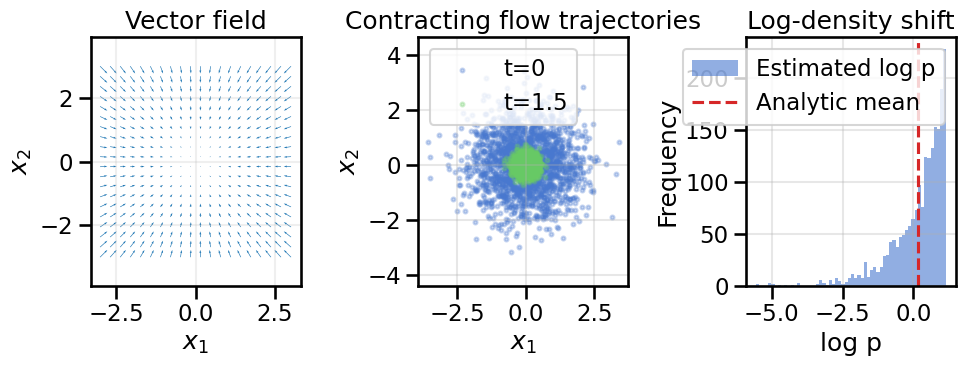

RMSE between simulated and analytic endpoints: 7.975e-08
Mean absolute log-density error: 4.175e-06


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the vector field corresponding to the contracting flow
x1 = np.linspace(-3, 3, 20)
x2 = np.linspace(-3, 3, 20)
X1, X2 = np.meshgrid(x1, x2)
U = -X1
V = -X2

axes[0].quiver(X1, X2, U, V, color='tab:blue')
axes[0].set_title('Vector field')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)


axes[1].scatter(z0[:, 0].cpu(), z0[:, 1].cpu(), s=8, alpha=0.3, label='t=0')
axes[1].scatter(zT[:, 0].cpu(), zT[:, 1].cpu(), s=8, alpha=0.3, label=f't={T_final}')
axes[1].set_title('Contracting flow trajectories')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

axes[2].hist(logpT_est.cpu().numpy(), bins=60, alpha=0.6, label='Estimated log p')
axes[2].axvline(analytic_logp.mean().item(), color='tab:red', linestyle='--', label='Analytic mean')
axes[2].set_title('Log-density shift')
axes[2].set_xlabel('log p')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
plt.tight_layout()
plt.show()

rmse = torch.sqrt(torch.mean((zT - analytic_zT) ** 2)).item()
logp_error = torch.abs(logpT_est - analytic_logp).mean().item()
print(f'RMSE between simulated and analytic endpoints: {rmse:.3e}')
print(f'Mean absolute log-density error: {logp_error:.3e}')

The numerical flow contracts every trajectory toward the origin while the histogram of $\log p$ shifts by approximately $2 T$. The errors stay small because the velocity field is linear and the RK4 integrator tracks it well.

## Example 1D Continuous Normalizing Flow with Neural ODEs

Finally, we'll implement a simple continuous normalizing flow using a neural ODE to learn a target distribution. We'll define a neural network velocity field, integrate the ODE, and optimize the parameters to maximize likelihood on a simple 1D distribution.

Note: this demo requires the `torchdiffeq` package. You can install it via pip if you haven't already if you wish to run the demo.

In [7]:
#%pip install torchdiffeq

In [ ]:
#| code-fold: false
from torchdiffeq import odeint

def sample_base_gaussian(n: int) -> Tensor:
    return torch.normal(0.0, 1.0, size=(n, 1), device=device)

def log_prob_base_gaussian(x: Tensor) -> Tensor:
    const = -0.5 * torch.log(2 * torch.pi * torch.ones_like(x))
    return -0.5 * x.pow(2) + const


_UNIF_LOW, _UNIF_HIGH = -3.0, 3.0
def sample_base_uniform(n: int, low: float = _UNIF_LOW, high: float = _UNIF_HIGH) -> Tensor:
    return low + (high - low) * torch.rand(n, 1, device=device)

def log_prob_base_uniform(x: Tensor, low: float = _UNIF_LOW, high: float = _UNIF_HIGH) -> Tensor:
    width = high - low
    logp = -torch.log(torch.tensor(width, device=x.device)) * torch.ones_like(x)
    inside = (x >= low) & (x <= high)
    # out-of-support points get -inf log-probability
    return torch.where(inside, logp, torch.full_like(x, float("-inf")))

# We will use the uniform base distribution, but you can switch it to the Gaussian if desired
# by changing these assignments below.
sample_base = sample_base_uniform
log_prob_base = log_prob_base_uniform

def sample_target(n):
    # mixture of two Gaussians, 0.5 each
    mix = torch.randint(0, 2, (n, 1), device=device).float()
    means = -2 * (1 - mix) + 2 * mix
    return means + 0.4 * torch.randn(n, 1, device=device)

def log_prob_target(x):
    # mixture density for visualization only
    denom = 0.4 * torch.sqrt(2 * torch.pi * torch.ones_like(x))
    p1 = torch.exp(-0.5 * ((x + 2) / 0.4)**2) / denom
    p2 = torch.exp(-0.5 * ((x - 2) / 0.4)**2) / denom
    return torch.log(0.5 * (p1 + p2) + 1e-9)

# Define the neural network vector field f(x,t)
class CNF1D(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1 + 1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, t, x):
        if isinstance(t, torch.Tensor):
            t = t.to(x.device)
        t_in = torch.ones_like(x) * t
        return self.net(torch.cat([x, t_in], dim=1))


# CNF dynamics: dx/dt = f, d(logp)/dt = -∂f/∂x
class CNFDynamics(nn.Module):
    def __init__(self, fnet):
        super().__init__()
        self.fnet = fnet

    def forward(self, t, states):
        x, logp = states
        x = x.requires_grad_(True)
        f = self.fnet(t, x)
        df_dx = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
        dlogp = -df_dx
        return f, dlogp

fnet = CNF1D(hidden=32).to(device)
dynamics = CNFDynamics(fnet)
optimizer = optim.AdamW(fnet.parameters(), lr=1e-3)

for step in range(600):
    x0 = sample_base(256)
    logp0 = log_prob_base(x0)

    # ensure time tensor is on the same device as the model/state
    t = torch.tensor([0.0, 1.0], device=device)
    x1, logp1 = odeint(dynamics, (x0, logp0), t)
    x1, logp1 = x1[-1], logp1[-1]

    # Negative log-likelihood under target (maximum likelihood)
    logpt = log_prob_target(x1)
    loss = -(logpt - logp1).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, loss {loss.item():.4f}")
print("Training complete.")


Step 0, loss 2.3605
Step 50, loss 1.5631
Step 100, loss 1.0494
Step 150, loss 0.4459
Step 200, loss 0.1519
Step 250, loss 0.1067
Step 300, loss 0.1081
Step 350, loss 0.0705
Step 400, loss 0.0784
Step 450, loss 0.1421
Step 500, loss 0.0940
Step 550, loss 0.0485
Training complete.


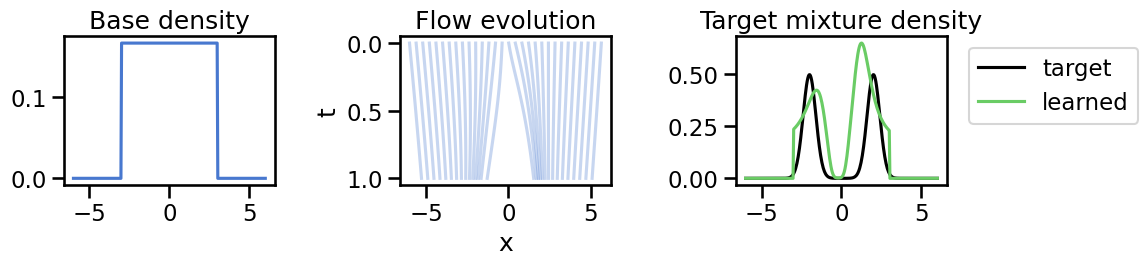

In [ ]:
with torch.no_grad():
    xs = torch.linspace(-6, 6, 300).unsqueeze(1)
    t = torch.linspace(0, 1, 20)
    xt = odeint(lambda t, x: fnet(t, x), xs, t)

# Prepare a tensor that requires grad to compute ∂f/∂x
xs_grad = xs.clone().detach().requires_grad_(True)
f_vals = fnet(0.5, xs_grad)

# Plot flow evolution
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].set_title("Base density")
axes[1].set_title("Flow evolution")
axes[2].set_title("Target mixture density")

# Plot the Base distribution
xplot = xs.squeeze().cpu().numpy()
p_base = torch.exp(log_prob_base(xs_grad)).squeeze().detach().cpu().numpy()
p_target = torch.exp(log_prob_target(xs_grad)).squeeze().detach().cpu().numpy()
axes[0].plot(xplot, p_base)

# Evolution (trajectories)
xt_np = xt.detach().cpu().numpy()
for i in range(0, len(xs), 10):
    axes[1].plot(xt_np[:, i, 0], t.cpu().numpy(), color="C0", alpha=0.3)
axes[1].invert_yaxis()
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")

# Target vs learned
# compute df/dx using autograd
df_dx = torch.autograd.grad(f_vals, xs_grad, torch.ones_like(f_vals), create_graph=False)[0]
p_learned = torch.exp(log_prob_base(xs_grad) - df_dx).squeeze().detach().cpu().numpy()

axes[2].plot(xplot, p_target, label="target", color="black")
axes[2].plot(xplot, p_learned, label="learned", color="C1")
axes[2].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


We can see from the center plot how the initial distribution (blue) is smoothly transformed into the target distribution over time via the learned velocity field, although not perfectly in this example given the small network and simulation time we gave it. 

::: {.callout-tip appearance="default"}
### Experiment: Effect of Base Distribution and Smoothness on the Flow Field

Changing some of the below will help you see some possible failure modes of continuous normalizing flows:

- Try changing the base distribution from standard normal to a uniform distribution. How does this affect the learned flow? What happens if the base distribution has bounded support that is different from the target distribution? How does the flow handle this?
- Experiment with the smoothness of the velocity field by changing the architecture of the neural network (e.g., number of layers, activation functions, weight decay to promote regularization). How does this impact the quality of the learned distribution and the stability of training?
- Change `sample_base` to use more or fewer samples. How does the number of samples used to estimate the likelihood affect the training dynamics, total time taken, and the final learned distribution?

:::

## Summary and Next Steps

- Continuous normalizing flows are the infinitesimal limit of discrete flows, replacing layerwise Jacobians with a divergence term integrated over time.
- The continuity equation formalizes conservation of probability mass and links particle dynamics to density evolution.
- Divergence-free flows preserve density while compressive fields increase log-density.
- Neural ODEs show that we can learn velocity fields that sculpt data distributions without explicit discrete blocks. Inference now involves solving an ODE rather than evaluating a fixed sequence of transformations.
- However, ODE solving can be computationally intensive, especially in high dimensions or with complex velocity fields, since this will necessitate longer numerical integration times. Moreover, computing the trace of the Jacobian remains a bottleneck.

What if we could get some of the benefits of continuous flows without the computational overhead of ODE solving? In the next chapter, we will explore *score-based generative models*, which learn to model data distributions by estimating something called a *score function*. These models can be seen as a special case of continuous flows, but they avoid the need for expensive ODE integration by leveraging denoising techniques and stochastic sampling methods that will ultimately lead us to diffusion models and flow matching approaches in the coming chapters.